In [3]:
!pip install vtk
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 13.3 MB/s eta 0:00:00


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import vtkmodules.all as vtk
from vtkmodules.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import meshio
from scipy.spatial.distance import cdist

In [5]:
from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Mounted at /content/drive


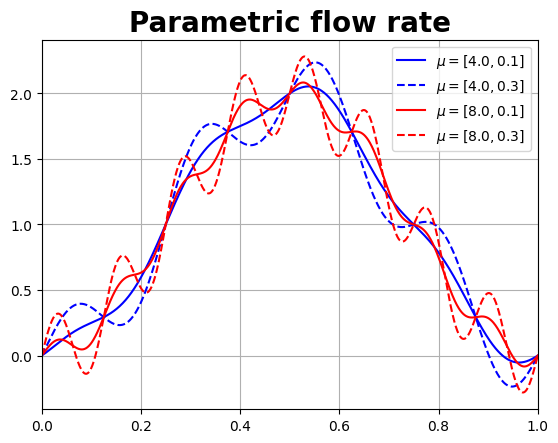

In [6]:
fields = {'velocity', 'pressure'}

basis_space, sv_space, Nh_space, nmodes_space = dict(), dict(), dict(), dict()
basis_time, sv_time, Nh_time, nmodes_time = dict(), dict(), dict(), dict()
nmodes = dict()
'/content/drive/MyDrive/dati/input_data.npy'
for field in fields:
    basis_space[field] = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'basis', field, 'space_basis.npy'))  # spatial basis
    sv_space[field] = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'basis', field, 'space_sv.npy'))  # singular values in space
    Nh_space[field], nmodes_space[field] = basis_space[field].shape  # number of FOM and ROM unknowns in space
    basis_time[field] = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'basis', field, 'time_basis.npy'))  # temporal basis
    sv_time[field] = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'basis', field, 'time_sv.npy'))  # singular values in time
    Nh_time[field], nmodes_time[field] = basis_time[field].shape  # number of FOM and ROM unknowns in time
    nmodes[field] = nmodes_space[field] * nmodes_time[field]  # total dimension of the reduced basis

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
N_supr_space = basis_space['pressure'].shape[1] + 66  # number of extra bases in space for the velocity
N_supr_time = 5  # number of extra bases in time for the velocity

# STORE ORIGINAL NUMBER OF VELOCITY MODES IN THE DICTIONARY
nmodes_space['velocity_full'] = nmodes_space['velocity']
nmodes_time['velocity_full'] = nmodes_time['velocity']
nmodes['velocity_full'] = nmodes['velocity']

# UPDATE THE NUMBER OF VELOCITY MODES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
nmodes_space['velocity'] -= N_supr_space
nmodes_time['velocity'] -= N_supr_time
nmodes['velocity'] = nmodes_space['velocity'] * nmodes_time['velocity']

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
basis_space['velocity'] = basis_space['velocity'][:, :nmodes_space['velocity']]
basis_time['velocity'] = basis_time['velocity'][:, :nmodes_time['velocity']]

# LOAD NORMED BASIS MATRICES IN SPACE (needed for projections)
basis_space_normed = dict()
#norm = dict()
for field in fields:
    #norm[field] = load_npz(os.path.join('dataset', 'norms', f'norm_{field}.npz'))
    #basis_space_normed[field] = norm[field].dot(basis_space[field])
    #np.save(os.path.join('dataset', 'basis', field, 'basis_space_normed.npy'), basis_space_normed[field])
    basis_space_normed[field] = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'basis', field, 'basis_space_normed.npy'))

# n_snaps = None  # change to a number if you want to load only a subset of snapshots
# _sol = np.load(os.path.join('dataset', 'RB_data', 'solutions.npy'))[:n_snaps]
_sol = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'RB_data', 'solutions.npy'))

solutions = dict()

# velocity reduced solutions (with and without supremizers and stabilizers)
solutions['velocity_full'] = np.reshape(_sol[:, :nmodes['velocity_full']],
                                        (-1, nmodes_space['velocity_full'], nmodes_time['velocity_full']))
solutions['velocity'] = solutions['velocity_full'][:, :nmodes_space['velocity'], :nmodes_time['velocity']]

# pressure reduced solutions
solutions['pressure'] = np.reshape(_sol[:, :nmodes['pressure']],
                                   (-1, nmodes_space['pressure'], nmodes_time['pressure']))

##################################################################
def project(sol, normed_basis_space, basis_time):
    """ Project a full-order solution in space-time."""
    return (normed_basis_space.T.dot(sol)).dot(basis_time) # !! REMARK: here we need the normed basis in space !!

def expand(sol, basis_space, basis_time):
    """ Expand a reduced-order solution in space-time."""
    return (basis_space.dot(sol)).dot(basis_time.T)

##################################################################

params = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'RB_data', 'parameters.npy'))
params = np.delete(params, 2, axis=1)  # one column is useless and we delete it

Q = lambda t, mu, T=1: 1 - np.cos(2*np.pi*t/T) + mu[1] * np.sin(mu[0]*2*np.pi*t/T)

times = np.linspace(0,1,1000)
plt.plot(times, Q(times, [4.0, 0.1]), 'b-', label=r"$\mu = [4.0, 0.1]$")
plt.plot(times, Q(times, [4.0, 0.3]), 'b--', label=r"$\mu = [4.0, 0.3]$")
plt.plot(times, Q(times, [8.0, 0.1]), 'r-', label=r"$\mu = [8.0, 0.1]$")
plt.plot(times, Q(times, [8.0, 0.3]), 'r--', label=r"$\mu = [8.0, 0.3]$")

plt.grid()
plt.xlim([0,1])
plt.legend()
plt.title("Parametric flow rate", fontweight='bold', fontsize=20)
plt.show()

In [7]:
print(solutions['velocity'].shape)
print(params.shape)

params = params.astype(np.float32)
solutions['velocity'] = solutions['velocity'].astype(np.float32)
solutions['pressure'] = solutions['pressure'].astype(np.float32)

(1950, 39, 16)
(1950, 3)


In [8]:
device = torch.device("cuda")

class Fluid_Dataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        target_data = self.targets[idx]
        return input_data, target_data

N_data=params.shape[0]
indices = torch.randperm(N_data)
ratio_data=0.8
train_size = int(ratio_data * N_data)
train_indices = indices[:train_size]
test_indices=indices[train_size:]

mean_params=np.mean(params,axis=0)
std_params=np.std(params,axis=0)
params_norm=(params-mean_params)/std_params

train_params=params_norm[train_indices]
test_params=params_norm[test_indices]

train_vel=solutions['velocity'][train_indices]
test_vel=solutions['velocity'][test_indices]

train_press=solutions['pressure'][train_indices]
test_press=solutions['pressure'][test_indices]
# dataset = Fluid_Dataset(params_norm, solutions['velocity'])

# dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

print(test_vel.shape,train_vel.shape)


(390, 39, 16) (1560, 39, 16)


In [9]:
class MLP_vel_model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = torch.nn.Linear(3,128)
        self.fc2 = torch.nn.Linear(128,128)
        self.fc3 = torch.nn.Linear(128,128)
        self.fc4 = torch.nn.Linear(128,39*16)

        self.relu = torch.nn.ReLU()
        self.bn = torch.nn.BatchNorm1d(128)

        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, Z):
        Z = torch.flatten(Z, 1)
        Z = self.relu(self.bn(self.fc1(Z))) #first layer
        Z = self.relu(self.bn(self.fc2(Z))) #second layer
        Z = self.relu(self.bn(self.fc3(Z))) #third layer
        Z = self.fc4(Z)                     #output layer
        Z = Z.view(-1, 39, 16)
        return Z



In [10]:
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()  # Important set model to train mode (affects dropout, batch norm etc)

    loss_history = []
    accuracy_history = []
    for batch_idx, (data, target) in enumerate(train_loader):

        data=data.to(device)
        target=target.to(device)
        output = model.forward(data)  # TODO
        loss =  criterion(output, target)

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights

        loss_history.append(loss.item())

        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx} batch_loss={loss.item()/len(data):0.2e}"
            )

    return loss_history

@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important set model to eval mode (affects dropout, batch norm etc)
    test_loss = 0
    test_rel_loss = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)
        test_rel_loss += criterion(output, target).item()/torch.norm(target).item() * len(data)

    test_loss /= len(val_loader.dataset)
    test_rel_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f} Average relative error: {:.4f}".format(
            test_loss, test_rel_loss
        )
    )
    return test_loss,test_rel_loss


def run_vel_training(num_epochs, lr, batch_size, device="cuda"):

    train_set = Fluid_Dataset(train_params, train_vel)

    val_set = Fluid_Dataset(test_params, test_vel)

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,  # Can be important for training
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    model = MLP_vel_model()
    model = model.to(device=device)
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        weight_decay=1e-4
    )
    criterion = torch.nn.functional.mse_loss

    # ===== Train Model =====
    train_loss_history = []
    val_loss_history = []
    val_rel_loss_history = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(
            model, device, train_loader, optimizer, epoch, criterion
        )
        train_loss_history.extend(train_loss)

        val_loss,val_rel_loss= validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_rel_loss_history.append(val_rel_loss)

    # ===== Plot training curves =====
    n_train = len(train_loss_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure()
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.figure()
    plt.plot(t_val, val_rel_loss_history, label="Val rel err")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("rel err")

    return model



Train Epoch: 1-0 batch_loss=1.67e+00
Train Epoch: 1-4 batch_loss=1.66e+00
Train Epoch: 1-8 batch_loss=1.64e+00
Train Epoch: 1-12 batch_loss=1.66e+00
Train Epoch: 1-16 batch_loss=1.65e+00
Train Epoch: 1-20 batch_loss=1.64e+00
Train Epoch: 1-24 batch_loss=1.62e+00
Train Epoch: 1-28 batch_loss=1.59e+00
Train Epoch: 1-32 batch_loss=1.61e+00
Train Epoch: 1-36 batch_loss=1.58e+00
Train Epoch: 1-40 batch_loss=1.58e+00
Train Epoch: 1-44 batch_loss=1.56e+00
Test set: Average loss: 49.3681 Average relative error: 0.0488
Train Epoch: 2-0 batch_loss=1.55e+00
Train Epoch: 2-4 batch_loss=1.55e+00
Train Epoch: 2-8 batch_loss=1.54e+00
Train Epoch: 2-12 batch_loss=1.50e+00
Train Epoch: 2-16 batch_loss=1.52e+00
Train Epoch: 2-20 batch_loss=1.52e+00
Train Epoch: 2-24 batch_loss=1.48e+00
Train Epoch: 2-28 batch_loss=1.48e+00
Train Epoch: 2-32 batch_loss=1.49e+00
Train Epoch: 2-36 batch_loss=1.46e+00
Train Epoch: 2-40 batch_loss=1.46e+00
Train Epoch: 2-44 batch_loss=1.42e+00
Test set: Average loss: 45.7141

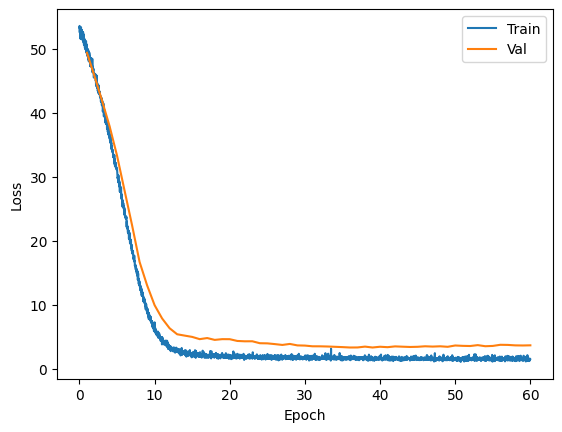

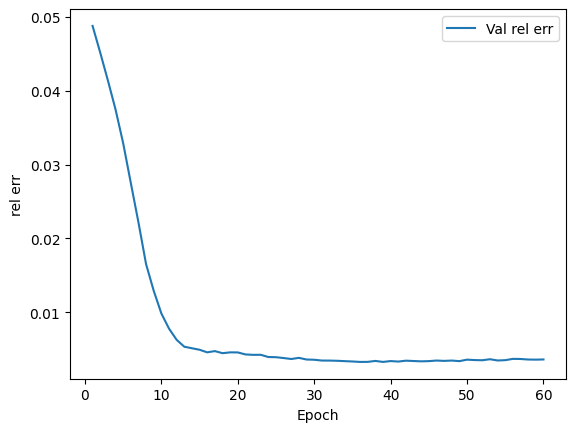

In [11]:
lr = 0.01
batch_size = 32
num_epochs = 60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_trained=run_vel_training(num_epochs, lr, batch_size, device)

In [22]:
def read_vtk(filename):
    """Read .vtk file and return the polydata"""

    fn_dir, fn_ext = os.path.splitext(filename)

    if fn_ext == '.vtk':
        reader = vtk.vtkPolyDataReader()
    elif fn_ext == '.vtp':
        reader = vtk.vtkXMLPolyDataReader()
    elif fn_ext == '.stl':
        reader = vtk.vtkSTLReader()
    elif fn_ext == '.obj':
        reader = vtk.vtkOBJReader()
    elif fn_ext == '.vtu':
        reader = vtk.vtkXMLUnstructuredGridReader()
    elif fn_ext == '.pvtu':
        reader = vtk.vtkXMLPUnstructuredGridReader()
    else:
        raise ValueError(F"File extension {fn_ext} not supported")

    reader.SetFileName(filename)
    reader.Update(0)
    mesh = reader.GetOutput()

    return mesh

def write_vtk(mesh, fn):
    """ Write a mesh (vtk polydata or unstructured grid) to disk """

    _, extension = os.path.splitext(fn)

    if extension == '.vtk':
        writer = vtk.vtkPolyDataWriter()
    elif extension == '.stl':
        writer = vtk.vtkSTLWriter()
    elif extension == '.vtp':
        writer = vtk.vtkXMLPolyDataWriter()
    elif extension == '.vtu':
        writer = vtk.vtkXMLUnstructuredGridWriter()
    elif extension == '.obj':
        writer = vtk.vtkOBJWriter()
    else:
        raise ValueError(f"Unrecognized extension {extension}")

    writer.SetInputData(mesh)
    writer.SetFileName(fn)
    writer.Update(0)
    writer.Write()

    return

def add_array(mesh, array, name):
    """Add numpy array as new field to a vtk file"""

    new_array = numpy_to_vtk(array)
    new_array.SetName(name)
    mesh.GetPointData().AddArray(new_array)

    return mesh

def compute_matching_idxs():
    """Compute correspondences bewteen indices on the .vtu and on the .mesh file for plotting"""

    mesh = read_vtk(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries', 'bif_sym_alpha50_h0.10_ref.vtu'))
    points = vtk_to_numpy(mesh.GetPoints().GetData())

    mesh_2 = meshio.read(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries','bif_sym_alpha50_h0.10.mesh'))
    points_2 = mesh_2.points

    dist = cdist(mesh_2.points, points, metric='euclidean')

    idxs = np.argmin(dist, axis=0)

    return idxs


def visualize_solution(field_array, fields=None, step_t=10):
    """ Export the solution corresponding to the n-th snapshot (every step_t steps) to a .vtu file."""

    if fields is None:
        fields = {'velocity': 3, 'pressure': 1}  # fields and corresponding dimensions

    os.makedirs('solutions', exist_ok=True)

    idxs = compute_matching_idxs()

    mesh = read_vtk(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries', 'bif_sym_alpha50_h0.10.vtu'))

    fom_solution = dict()
    for field in fields:
        # print(f"Processing field {field} - Dimension: {fields[field]}")
        cur_idxs = np.hstack([idxs + k * (Nh_space[field]//fields[field]) for k in range(fields[field])])
        fom_solution[field] = expand(field_array, basis_space[field], basis_time[field])[cur_idxs]
        print(fom_solution[field].shape)

    for cnt_t in range(0, Nh_time['velocity'], step_t):
        # print(f"\nProcessing timestep {cnt_t} of {Nh_time['velocity']}")
        for field in fields:
            cur_fom_solution = np.reshape(fom_solution[field][:, cnt_t], (fields[field], -1)).T
            mesh = add_array(mesh, cur_fom_solution, field)

        # write_vtk(mesh, os.path.join('solutions', f"solution_{n}_{cnt_t}" + '.vtu'))
        write_vtk(mesh, os.path.join('solutions', f"solution_{cnt_t}" + '.vtu'))

    return


In [27]:
model_trained.eval()

input_tensor = torch.tensor(test_params[0,:], dtype=torch.float32)  # Trasforma in tensore
input_tensor = input_tensor.unsqueeze(dim=0)
input_tensor = input_tensor.to(device)  # Se usi la GPU

with torch.no_grad():
    output_visual = model_trained(input_tensor)
    output_visual=output_visual[0]
    print(output_visual.shape)

visualize_solution(output_visual.cpu().numpy() ,fields={'velocity': 3},step_t=5)

torch.Size([39, 16])
(10656, 1000)


In [ ]:
!zip -r solutions.zip solutions
from google.colab import files
files.download('solutions.zip')